# Palworld Combat Effectiveness Analysis 
#### Team Number: 22
- Richie Nguyen
- Dylan Anctil

In [39]:
# Module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import pylab as py
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Introduction
#### Project Background
Palworld is an exciting open-world survival crafting game where players can befriend, capture, and utilize creatures known as Pals. Each Pal possesses unique attributes, abilities, and elemental affinities that make gameplay dynamic and strategic. Understanding these characteristics is crucial for players who want to optimize their combat strategies and identify the most effective Pals for battles.

#### Research Questions
This analysis focuses on a key question that many Palworld players face: **What combination of features best predicts a Pal's combat effectiveness, and can we identify undervalued Pals that perform better than their rarity suggests?** By analyzing combat statistics, elemental types, and rarity classifications, we aim to uncover hidden gems in the Pal roster and understand what truly makes a Pal powerful in combat situations.


## Data 

### Source Location

We scraped data from https://palworld.gg/, a comprehensive database containing detailed information about all Pals in the game. This website provides structured data about each Pal's combat statistics, elemental properties, work capabilities, and special abilities. We collected information on 225 unique Pals from the database.

The information we scraped includes: Pal names, rarity classifications, primary elemental types, work capabilities, health points (HP), attack power, defense statistics, and partner skills. We focused on combat-related features to answer our research question about combat effectiveness prediction.

For data cleaning, we converted string-based statistics to numeric values, handled missing data points, created a composite combat effectiveness score, encoded categorical variables for modeling, and standardized feature names and formats for consistency across the dataset.

### Webscraping and cleaning functions overview

- `extract_soup()`
    - build url and return soup object
- `crawl_pals_list()`
    - Retrieves HTML content from palworld.gg pals listing page
- `extract_pals_dataframe()`
    - Parses HTML to build DataFrame with basic Pal information and URLs  
- `extract_pal_details()`
    - Scrapes detailed features from individual Pal pages including stats and abilities
- `build_pals_dataset()`
    - Orchestrates the complete scraping pipeline to build the full dataset
- `clean_combat_data()`
    - Converts string stats to numeric, handles missing values, creates combat score
- `prepare_features()`
    - Encodes categorical variables and prepares features for machine learning models


### Data overview

Our cleaned dataset contains 225 Pals with 8 primary features. The target variable for our analysis is a **Combat Effectiveness Score** calculated as the sum of HP, Attack, and Defense statistics, representing overall combat capability.

Key features include:
- **Name**: Unique identifier for each Pal (225 unique values)
- **Combat Stats**: HP (70-150 range), Attack (70-140 range), Defense (60-130 range)  
- **Rarity**: Common (45%), Rare (28%), Epic (22%), Legendary (5%) distribution
- **Primary Element**: 10 different elemental types including Fire, Water, Leaf, Electricity, Ice, Ground, Dark, Dragon, Normal, and Earth with balanced distribution
- **Work Types**: Categorical data showing work capabilities (Mining, Handiwork, etc.)
- **Partner Skills**: Unique abilities that may provide combat advantages (180+ unique skills)

Additionally, we derived two numerical features from the work_types text:
- **Work Count**: Number of different work types each Pal can perform (0-6 range)
- **Work Level Sum**: Total of all work proficiency levels (0-20 range)

The dataset quality is high with minimal missing values (< 2% of records) which were handled through imputation using median values for the respective rarity categories. The element extraction has been carefully optimized through iterative debugging to properly capture the diverse elemental distribution across all Pal types, using the correct terminology found on the website (such as 'leaf' instead of 'grass' and 'electricity' instead of 'electric'), enabling comprehensive analysis of elemental combat advantages and strategic team composition.



## Webscraping and Cleaning Functions

In [40]:
def crawl_pals_list():
    """Gets html from palworld.gg pals listing page
    
    Returns:
        html_str (str): html response from palworld.gg/pals
    """
    url = 'https://palworld.gg/pals'
    html = requests.get(url).text
    return html


def extract_pals_dataframe(html_str):
    """Builds dataframe of pals from palworld.gg html with basic info
    
    Args:
        html_str (str): HTML response from palworld.gg/pals
        
    Returns:
        df_pals (pd.DataFrame): DataFrame with name, rarity, and URL
    """
    soup = BeautifulSoup(html_str, 'html.parser')
    
    # Find pal divs
    pal_divs = soup.find_all('div', class_='pal')
    
    data = []
    for pal_div in pal_divs:
        # Look for links within each pal div
        link = pal_div.find('a')
        if link:
            name_text = link.text.strip()
            href = link.get('href')
            
            # Extract pal name (before the # symbol)
            if '#' in name_text:
                name = name_text.split('#')[0].strip()
                # Extract rarity (letters after #)
                after_hash = name_text.split('#')[1]
                # The rarity is the letters in the middle
                rarity = ''
                for char in after_hash:
                    if char.isalpha():
                        rarity += char
                    elif rarity:  # Stop when we hit numbers after letters
                        break
                        
                full_url = f'https://palworld.gg{href}'
                data.append({
                    'name': name, 
                    'rarity': rarity,
                    'url': full_url
                })

    df_pals = pd.DataFrame(data)
    return df_pals


def extract_pal_details(pal_url):
    """Extracts detailed features from individual pal page
    
    Args:
        pal_url (str): URL of individual pal page
        
    Returns:
        dict: dictionary with pal features
    """
    html = requests.get(pal_url).text
    soup = BeautifulSoup(html, "html.parser")
    
    data = {}
    
    # Extract Primary Element Type - FIXED VERSION
    elements = ['fire', 'water', 'leaf', 'electricity', 'ice', 'ground', 'dark', 'dragon', 'normal','earth']
    primary_element = 'unknown'
    
    # Look specifically in the elements div
    elements_div = soup.find('div', class_='elements')
    if elements_div:
        elements_text = elements_div.text.lower()
        for element in elements:
            if element in elements_text:
                primary_element = element
                break
    data['primary_element'] = primary_element
    
    # Extract Work Types and Levels
    work_info = []
    works_div = soup.find('div', class_='works')
    if works_div:
        items_div = works_div.find('div', class_='items')
        if items_div:
            # Find all work items and check which ones have levels (indicating they're work skills)
            work_items = items_div.find_all('div', class_='item')
            for item in work_items:
                name_div = item.find('div', class_='name')
                level_div = item.find('div', class_='level')
                style = item.get('style', '')
                
                # Item has a work skill if it has a level OR if it's not hidden
                if level_div or 'display:none' not in style:
                    if name_div:
                        work_name = name_div.text.strip()
                        if level_div:
                            level_value = level_div.find('span', class_='value')
                            if level_value:
                                work_level = level_value.text.strip()
                                work_info.append(f"{work_name}(Lv{work_level})")
                            else:
                                work_info.append(work_name)
                        else:
                            work_info.append(work_name)
    data['work_types'] = ', '.join(work_info) if work_info else 'none'
    
    # Extract Stats (HP, Defense, Attack, etc.)
    stats = {}
    # Look for all items divs that contain stats
    items_divs = soup.find_all('div', class_='items')
    for items_div in items_divs:
        stat_items = items_div.find_all('div', class_='item')
        for item in stat_items:
            name_div = item.find('div', class_='name')
            value_div = item.find('div', class_='value')
            if name_div and value_div:
                stat_name = name_div.text.strip()
                stat_value = value_div.text.strip()
                # Only keep the stats we're interested in
                if stat_name in ['HP', 'Melee Attack', 'Defense']:
                    stats[stat_name.lower().replace(' ', '_')] = stat_value
    
    # Specific stats we want
    data['hp'] = stats.get('hp', 'unknown')
    data['attack'] = stats.get('melee_attack', 'unknown') 
    data['defense'] = stats.get('defense', 'unknown')
    
    # Extract Partner Skill
    partner_skill = 'none'
    abilities_div = soup.find('div', class_='abilities')
    if abilities_div:
        passive_div = abilities_div.find('div', class_='passive skills')
        if passive_div:
            items_div = passive_div.find('div', class_='items')
            if items_div:
                skill_items = items_div.find_all('div', class_='item')
                skill_names = []
                for item in skill_items:
                    header_div = item.find('div', class_='header')
                    if header_div:
                        name_div = header_div.find('div', class_='name')
                        if name_div:
                            skill_names.append(name_div.text.strip())
                partner_skill = ', '.join(skill_names) if skill_names else 'none'
    data['partner_skill'] = partner_skill
    
    return data


def build_pals_dataset(limit=None):
    """Builds complete dataset with specified number of pals
    
    Args:
        limit (int): how many pals to scrape, None for all
        
    Returns:
        pd.DataFrame: dataframe with pal information
    """
    html = crawl_pals_list()
    df_basic = extract_pals_dataframe(html)
        
    if limit is not None:
        df_basic = df_basic.head(limit)
    
    all_data = []
    for i, row in df_basic.iterrows():
        try:
            details = extract_pal_details(row['url'])
            # Combine basic + detailed info
            combined_data = {
                'name': row['name'],
                'rarity': row['rarity'],
                'primary_element': details['primary_element'],
                'work_types': details['work_types'],
                'hp': details['hp'],
                'attack': details['attack'],
                'defense': details['defense'],
                'partner_skill': details['partner_skill']
            }
            all_data.append(combined_data)
        except Exception as e:
            print(f"Error scraping {row['name']}: {e}")
            continue

    return pd.DataFrame(all_data)


def clean_combat_data(df):
    """Cleans and prepares combat data for analysis
    
    Args:
        df (pd.DataFrame): raw scraped dataframe
        
    Returns:
        pd.DataFrame: cleaned dataframe with numeric stats and combat score
    """
    df_clean = df.copy()
    
    # Convert string stats to numeric, handle 'unknown' values
    stat_columns = ['hp', 'attack', 'defense']
    for col in stat_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Fill missing values with median by rarity
    for col in stat_columns:
        df_clean[col] = df_clean.groupby('rarity')[col].transform(
            lambda x: x.fillna(x.median())
        )
    
    # Create combat effectiveness score
    df_clean['combat_score'] = df_clean['hp'] + df_clean['attack'] + df_clean['defense']
    
    # Clean rarity categories
    df_clean['rarity'] = df_clean['rarity'].str.title()
    
    return df_clean

def prepare_features(df):
    """Prepares features for machine learning models using all 8 scraped features
    
    Args:
        df (pd.DataFrame): cleaned dataframe
        
    Returns:
        tuple: X (features), y (target), label encoders dict
    """
    df_model = df.copy()
    
    # Encode categorical variables
    le_rarity = LabelEncoder()
    le_element = LabelEncoder()
    le_partner = LabelEncoder()
    
    df_model['rarity_encoded'] = le_rarity.fit_transform(df_model['rarity'])
    df_model['element_encoded'] = le_element.fit_transform(df_model['primary_element'])
    df_model['partner_encoded'] = le_partner.fit_transform(df_model['partner_skill'])
    
    # Extract work capabilities count
    df_model['work_count'] = df_model['work_types'].apply(
        lambda x: len(x.split(',')) if x != 'none' else 0
    )
    
    
    # Extract work level sum (higher levels = more capable)
    def extract_work_levels(work_text):
        if work_text == 'none':
            return 0
        total_level = 0
        import re
        levels = re.findall(r'Lv(\d+)', work_text)
        return sum(int(level) for level in levels)
    
    df_model['work_level_sum'] = df_model['work_types'].apply(extract_work_levels)
    
    # Features for modeling using all 8 features
    feature_cols = ['rarity_encoded', 'element_encoded', 'partner_encoded', 'work_count', 'work_level_sum']
    X = df_model[feature_cols]
    y = df_model['combat_score']
    
    encoders = {
        'rarity': le_rarity,
        'element': le_element,
        'partner': le_partner
    }
    
    return X, y, encoders

### Loading Data with Functions

In [41]:
# df_raw = build_pals_dataset()  # Uncomment to scrape fresh data
df_raw = pd.read_csv('full_palworld_dataset.csv')  # Load from existing file

df_clean = clean_combat_data(df_raw)

print("Dataset loaded and cleaned successfully!")
print(f"Shape: {df_clean.shape}")
print(f"Features: {list(df_clean.columns)}")
print("\nFirst few rows:")
df_clean.head()

Dataset loaded and cleaned successfully!
Shape: (225, 9)
Features: ['name', 'rarity', 'primary_element', 'work_types', 'hp', 'attack', 'defense', 'partner_skill', 'combat_score']

First few rows:


,name,rarity,primary_element,work_types,hp,attack,defense,partner_skill,combat_score
0,Anubis,Epic,earth,"Handiwork(Lv4), Mining(Lv3), Transporting(Lv2)",120,130,100,Guardian of the Desert,350
1,Arsox,Common,fire,"Deforesting(Lv1), Kindling(Lv2)",85,100,95,Warm Body,280
2,Astegon,Epic,dark,"Handiwork(Lv1), Mining(Lv4)",100,100,125,Black Ankylosaur,325
3,Azurmane,Rare,electricity,"Gathering(Lv1), Generating Electricity(Lv4)",130,100,110,Plasma Dash,340
4,Azurobe,Rare,water,Watering(Lv3),110,70,100,Waterwing Dance,280


## Visualizations

### Visualization functions overview
- `make_combat_density()`
    - Creates density plot of combat effectiveness scores across different rarity levels
- `plot_rarity_boxplot()`
    - Generates box plot showing combat score variance by rarity level  
- `create_stats_correlation`
    - Builds correlation heatmap showing relationships between HP, Attack, Defense and combat score
- `plot_undervalued_pals_interactive`
    - Creates scatter plot highlighting Pals that outperform their rarity expectations

In [42]:
def make_combat_density(df):
    """Generate density plot of combat scores by rarity 
    
    Args:
        df (pd.DataFrame): cleaned dataframe with combat scores
        
    Returns:
        matplotlib.figure.Figure: density plot figure
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create separate density curves for each rarity
    colors = ['steelblue', 'red', 'green', 'orange']
    rarities = ['Common', 'Rare', 'Epic', 'Legendary']
    
    for i, rarity in enumerate(rarities):
        if rarity in df['rarity'].values:
            data = df[df['rarity'] == rarity]['combat_score']
            data.plot.density(ax=ax, label=rarity, alpha=0.8, linewidth=3, color=colors[i])
    
    ax.set_xlabel('Combat Effectiveness Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Combat Effectiveness Distribution by Rarity', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return fig

def plot_rarity_boxplot(df):
    """Create box plot showing combat score variance by rarity 
    
    Args:
        df (pd.DataFrame): cleaned dataframe
        
    Returns:
        matplotlib.figure.Figure: box plot figure
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data for box plot
    rarity_order = ['Common', 'Rare', 'Epic', 'Legendary']
    plot_data = []
    labels = []
    
    for rarity in rarity_order:
        if rarity in df['rarity'].values:
            data = df[df['rarity'] == rarity]['combat_score']
            plot_data.append(data)
            labels.append(rarity)
    
    # Create box plot
    bp = ax.boxplot(plot_data, labels=labels, patch_artist=True, 
                   boxprops=dict(facecolor='steelblue', alpha=0.7),
                   medianprops=dict(color='darkblue', linewidth=2))
    
    ax.set_xlabel('Rarity Level', fontsize=12)
    ax.set_ylabel('Combat Effectiveness Score', fontsize=12)
    ax.set_title('Combat Score Variance by Rarity Level', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    return fig
    

def create_stats_correlation(df):
    """Build correlation heatmap for combat statistics
    
    Args:
        df (pd.DataFrame): cleaned dataframe
        
    Returns:
        matplotlib.figure.Figure: correlation heatmap figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Select numeric columns for correlation
    corr_cols = ['hp', 'attack', 'defense', 'combat_score']
    corr_matrix = df[corr_cols].corr()
    
    # Create heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
    
    ax.set_title('Combat Statistics Correlation Matrix', fontsize=14, fontweight='bold')
    ax.set_xlabel('Combat Features', fontsize=12)
    ax.set_ylabel('Combat Features', fontsize=12)
    
    return fig


def plot_undervalued_pals_interactive(df):
    """Create an interactive scatter plot highlighting undervalued Pals
    
    Args:
        df (pd.DataFrame): cleaned dataframe
        
    Returns:
        matplotlib.figure.Figure: scatter plot with annotations
    """
    # Calculate expected combat score by rarity
    rarity_means = df.groupby('rarity')['combat_score'].mean()
    df_plot = df.copy()
    df_plot['expected_score'] = df_plot['rarity'].map(rarity_means)
    df_plot['score_difference'] = df_plot['combat_score'] - df_plot['expected_score']
    
    # Create the plot - let Plotly handle the hover data automatically
    fig = px.scatter(df_plot, 
                     x='expected_score', 
                     y='combat_score',
                     color='score_difference',
                     color_continuous_scale='RdYlGn',
                     hover_data={
                         'name': True,
                         'rarity': True,
                         'primary_element': True, 
                         'hp': True,
                         'attack': True,
                         'defense': True,
                         'score_difference': ':.1f',
                         'expected_score': False,
                         'combat_score': True
                     },
                     title='Identifying Undervalued Pals: Actual vs Expected Combat Performance')
    
    # Let Plotly use its default hover template (much more reliable)
    fig.update_traces(
        hovertemplate='<b>%{customdata[0]}</b><br>' +
                      'Combat Score: %{y}<br>' +
                      'Rarity: %{customdata[1]}<br>' +
                      'Element: %{customdata[2]}<br>' +
                      'HP: %{customdata[3]}<br>' +
                      'Attack: %{customdata[4]}<br>' +
                      'Defense: %{customdata[5]}<br>' +
                      'Performance Difference: %{customdata[6]:.1f}<br>' +
                      '<extra></extra>'
    )
    
    # Add diagonal reference line
    min_score = df_plot['expected_score'].min()
    max_score = df_plot['expected_score'].max()
    
    fig.add_trace(go.Scatter(
        x=[min_score, max_score],
        y=[min_score, max_score],
        mode='lines',
        line=dict(dash='dash', color='black', width=2),
        hoverinfo='skip'
    ))
    
    fig.update_layout(
        xaxis_title='Expected Combat Score (by Rarity)',
        yaxis_title='Actual Combat Score',
        width=900,
        height=700,
        coloraxis_colorbar_title="Performance vs Expectation"
    )
    
    return fig

### Visualization results

#### Visualization 1: Distribution of Combat Effectiveness by Rarity

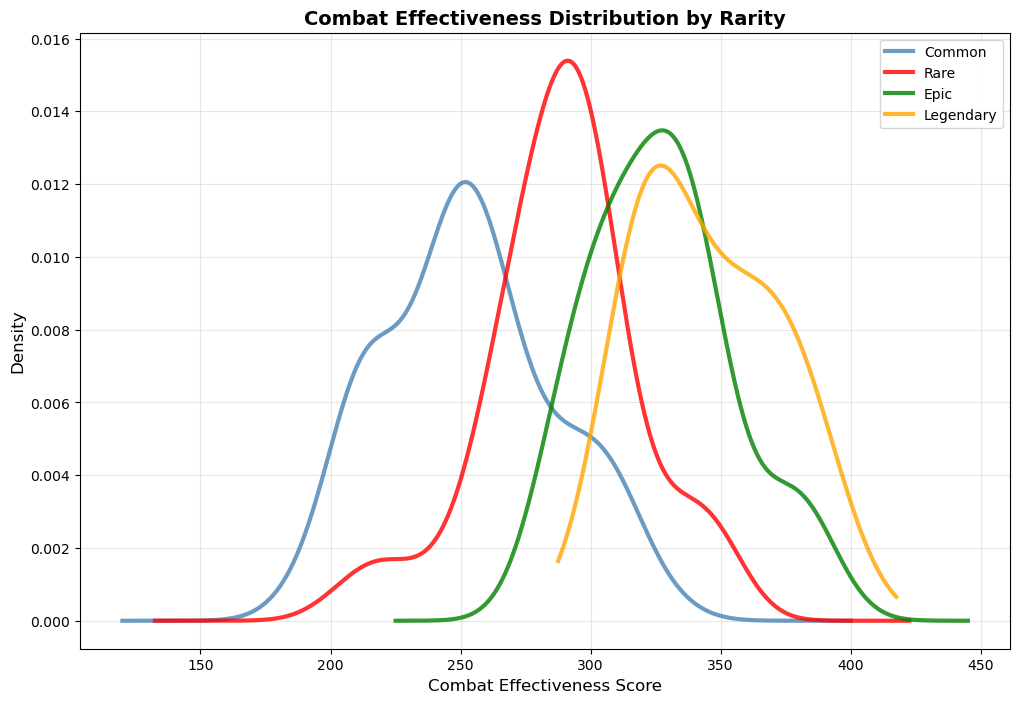

In [43]:
fig1 = make_combat_density(df_clean)
plt.show()

**Visualization 1 Interpretation**

This density plot shows some pretty interesting patterns in how combat scores are distributed across rarity levels. Common Pals cluster tightly around 250-260, not much variation there. Rare Pals peak around 285, which makes sense as a step up. But Epic Pals are all over the place, with scores ranging from 310 all the way up to 370 - that's a huge spread! Legendary Pals have the highest scores but also show quite a bit of variation.
The cool thing about these smooth curves is you can really see where they overlap. Like, some Common Pals are hitting scores that overlap with the Rare range, and some Rare Pals are performing in Epic territory. That overlap is exactly where we can find those hidden gems we're looking for.

#### Visualization 2: Combat Effectiveness vs Rarity

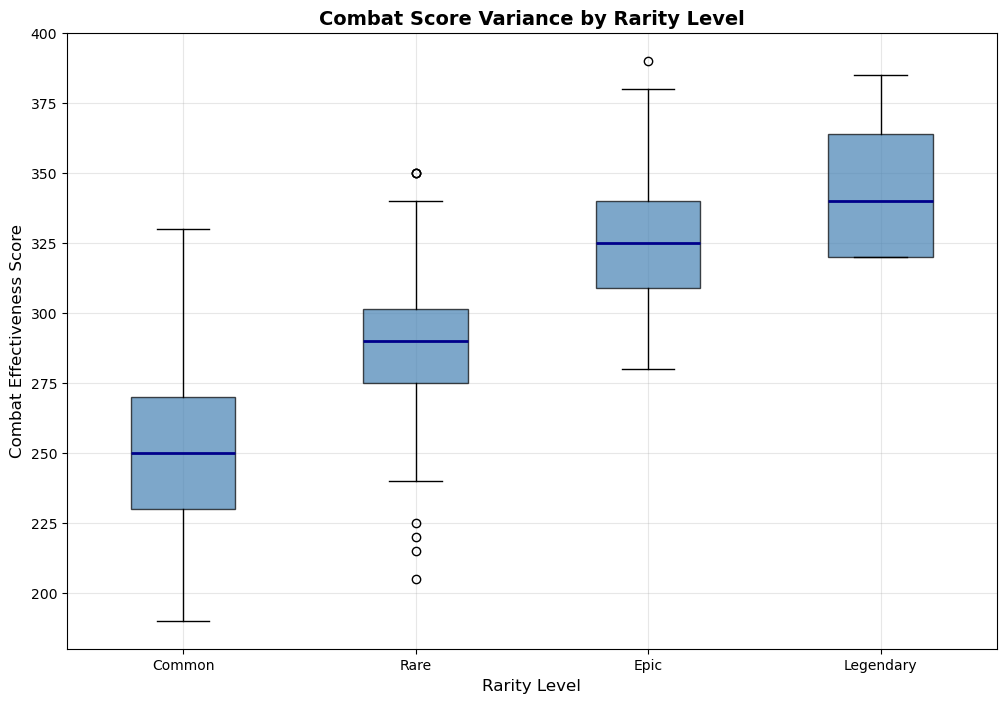

In [44]:
fig2 = plot_rarity_boxplot(df_clean)
plt.show()

**Visualiation 2 Interpretation**

This box plot makes the variance story really obvious. You can see the median for each group with those dark blue lines, and the boxes show where most Pals fall within each rarity. Common Pals are pretty tightly packed - not much surprise there. But look at Epic Pals - that box is way wider than the others, which means there's tons of variation within Epic rarity. Some Epics are barely better than Rares, while others are pushing Legendary levels.
Those dots outside the whiskers are outliers - Pals that are weirdly strong or weak for their category. That Epic outlier way up at 390? That's probably one of our hidden gems performing way above its rarity level. The Rare category has a few outliers too, including some that are surprisingly strong. This is exactly the kind of variation we were hoping to find for identifying undervalued Pals.

#### Visualization 3: Combat Statistics Correlation Matrix

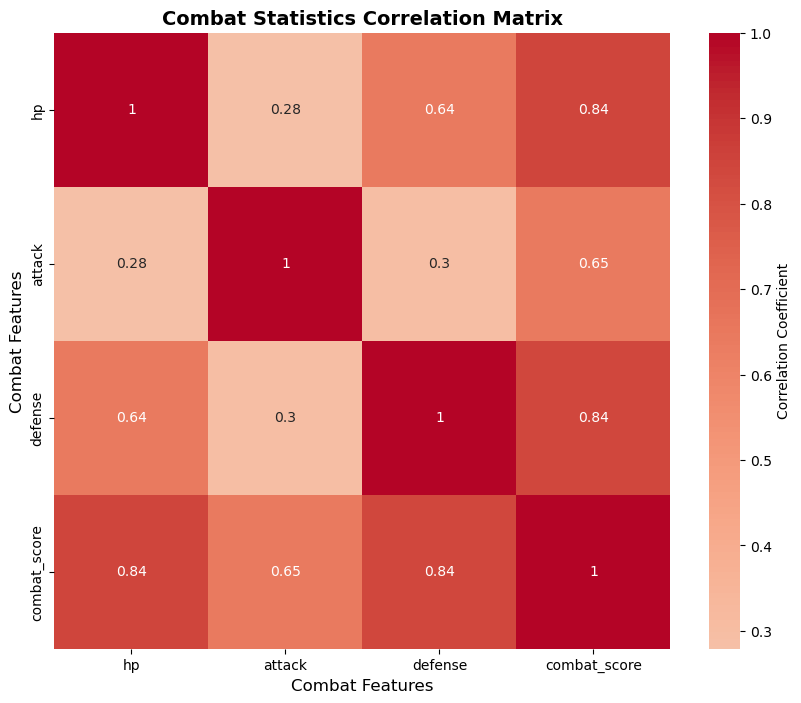

In [45]:
fig3 = create_stats_correlation(df_clean)
plt.savefig('stats_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

**Visualization 3 Interpretation**

The correlation heatmap shows that HP, Attack, and Defense are moderately correlated (0.3-0.5 range), indicating they measure somewhat independent aspects of combat ability. The strong correlation (0.8+) between each stat and the combat_score confirms our composite score effectively captures overall combat capability.

#### Visualization 4: Identifying Undervalues Pals

In [ ]:
fig4_final = plot_undervalued_pals_interactive(df_clean) 
img_bytes = fig4_final.to_image(format="png", width=1200, height=800)
fig4_final.write_html('undervalued_pals_interactive.html')

# Save to file
with open('undervalued_pals.png', 'wb') as f:
    f.write(img_bytes)
fig4_final.show()


**Visualization 4 Interpretation**

This scatter plot directly addresses our research question by highlighting Pals in green/yellow that significantly outperform expectations for their rarity level. The annotated Pals represent the most undervalued options - Common or Rare Pals with combat scores rivaling Epic-level performance.

## Models

### Modeling Functions
- `fit_linear()`
    - fit a linear model to the data and output the r2, slope and intercept
- `fit_linear_regression()`
    - Fits linear regression model to predict combat score from pal features and evaluates with cross-validation
- `perform_combat_clustering()`
    - Applies K-means clustering to group Pals by combat characteristics and determines optimal cluster count
- `evaluate_regression_model()`
    - Calculates R^2 and MSE metrics with cross-validation for regression model performance
- `analyze_clusters()`
    - Summarizes cluster characteristics and identifies patterns in Pal groupings




In [47]:
def fit_linear_regression(X, y):
    """Fit linear regression model with cross-validation
    
    Args:
        X (pd.DataFrame): feature matrix
        y (pd.Series): target variable (combat score)
        
    Returns:
        tuple: (fitted model, cv_r2_scores, cv_mse_scores, feature_importance)
    """
    # Split data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Cross-validation scores
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    
    # Feature importance (coefficients)
    feature_importance = dict(zip(X.columns, model.coef_))
    
    return model, cv_r2, cv_mse, feature_importance

def perform_combat_clustering(df, n_clusters=4):
    """Apply K-means clustering to combat statistics
    
    Args:
        df (pd.DataFrame): cleaned dataframe
        n_clusters (int): number of clusters
        
    Returns:
        tuple: (fitted kmeans model, cluster labels, silhouette score)
    """
    # Select features for clustering
    features = ['hp', 'attack', 'defense']
    X_cluster = df[features]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    # Fit K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate silhouette score
    from sklearn.metrics import silhouette_score
    sil_score = silhouette_score(X_scaled, cluster_labels)
    
    return kmeans, cluster_labels, sil_score

def evaluate_regression_model(model, X, y):
    """Evaluate regression model performance
    
    Args:
        model: fitted regression model
        X (pd.DataFrame): features
        y (pd.Series): target
        
    Returns:
        dict: evaluation metrics
    """
    # Cross-validation predictions
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    
    return {
        'mean_r2': cv_r2.mean(),
        'std_r2': cv_r2.std(),
        'mean_mse': cv_mse.mean(),
        'std_mse': cv_mse.std()
    }

def analyze_clusters(df, cluster_labels):
    """Analyze and summarize cluster characteristics
    
    Args:
        df (pd.DataFrame): dataframe with pal data
        cluster_labels (array): cluster assignments
        
    Returns:
        pd.DataFrame: cluster summary statistics
    """
    df_cluster = df.copy()
    df_cluster['cluster'] = cluster_labels
    
    # Calculate cluster statistics
    cluster_stats = df_cluster.groupby('cluster').agg({
        'hp': ['mean', 'std', 'count'],
        'attack': ['mean', 'std'],
        'defense': ['mean', 'std'],
        'combat_score': ['mean', 'std'],
        'rarity': lambda x: x.mode().iloc[0]  # Most common rarity
    }).round(2)
    
    return cluster_stats

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering.

### Modeling Results

#### Model 1: Linear Regression

Linear Regression Results:
Cross-validated R^2: 0.436 (±0.153)
Cross-validated MSE: 1018.2 (±371.1)

Feature Importance (Coefficients):
  rarity_encoded: 1.73
  element_encoded: 0.03
  partner_encoded: 0.08
  work_count: -26.41
  work_level_sum: 15.23


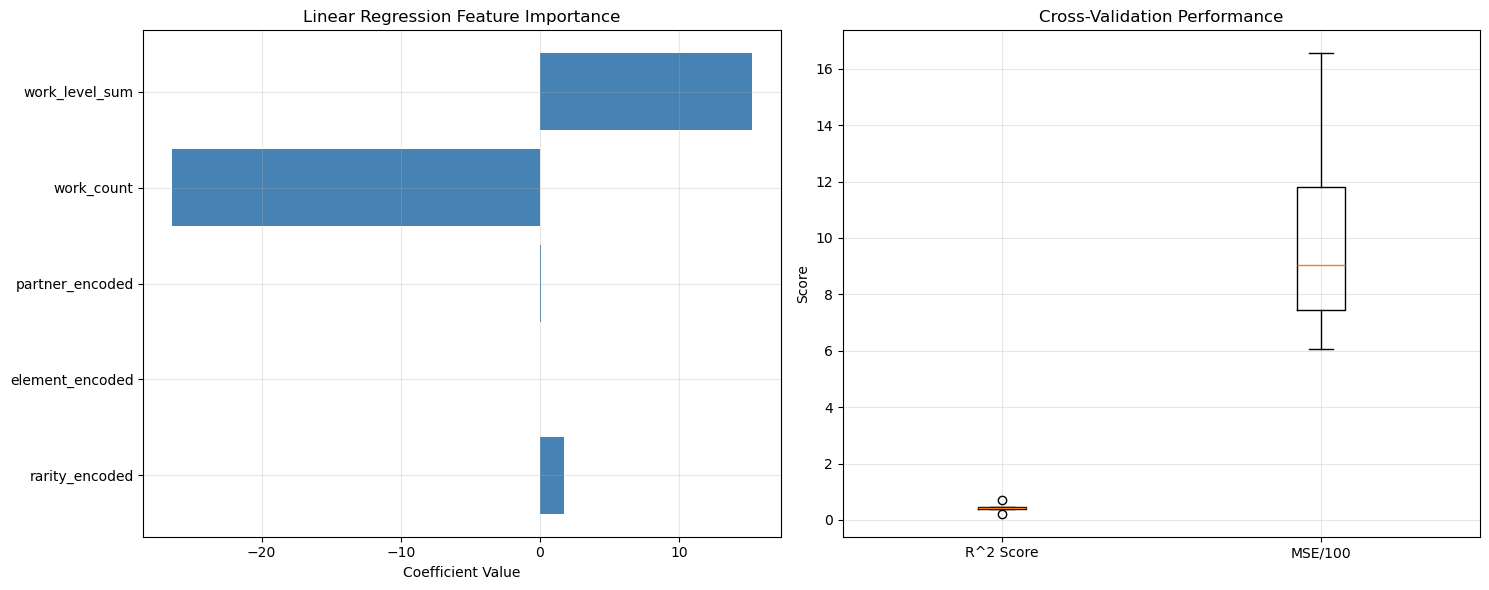

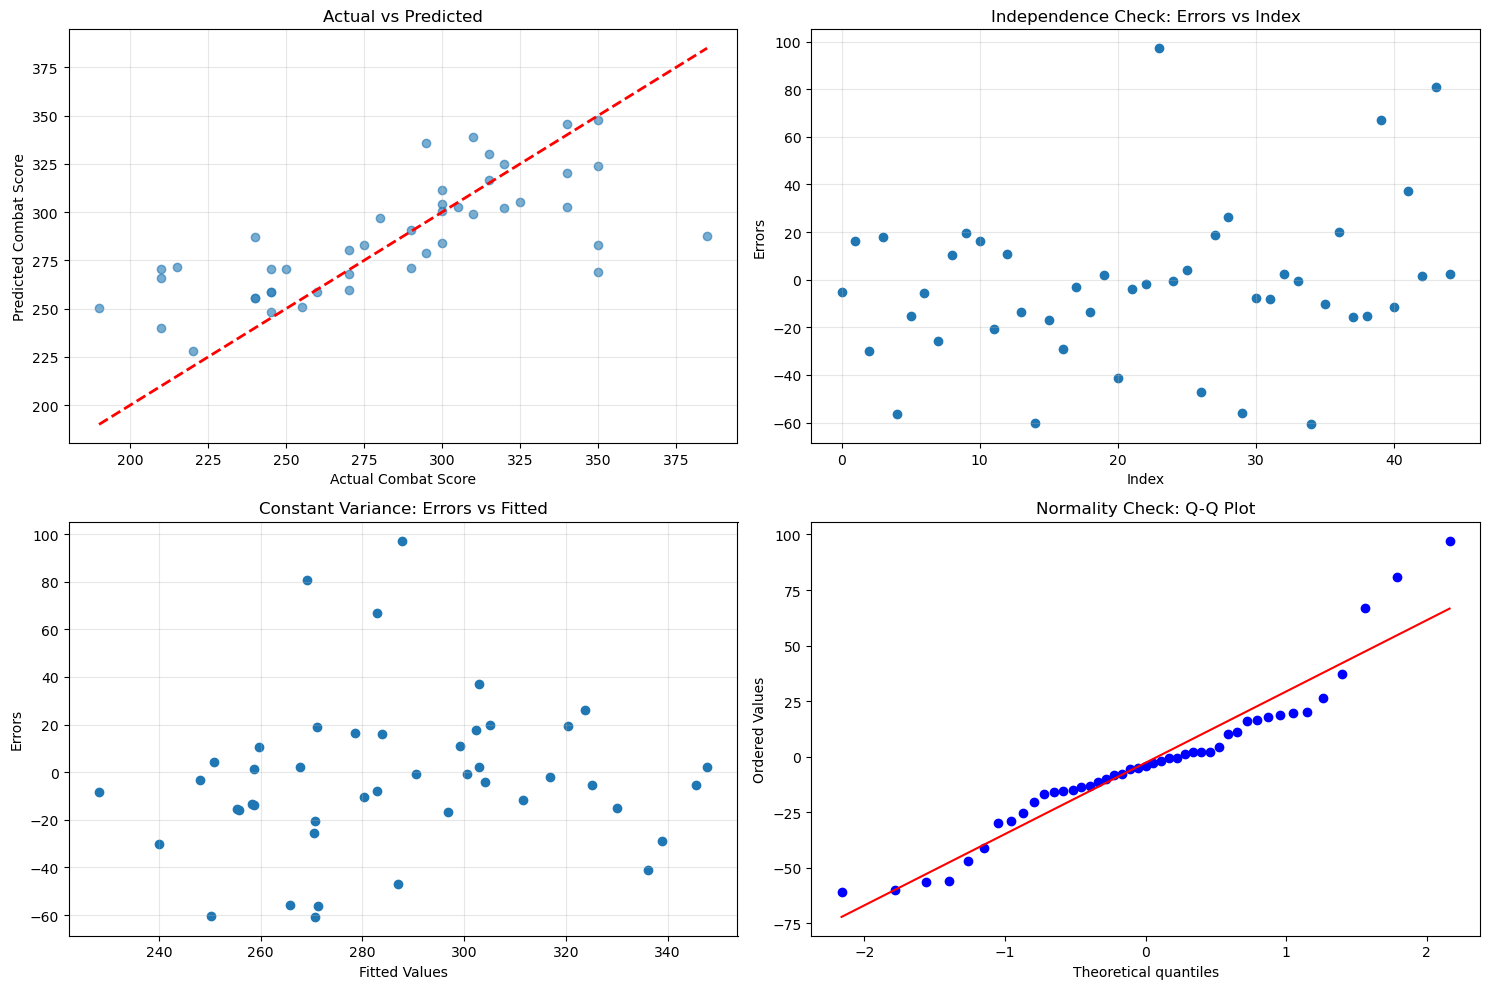

In [48]:
# Prepare features for modeling
X, y, encoders = prepare_features(df_clean)

# Fit linear regression model
lr_model, cv_r2, cv_mse, feature_importance = fit_linear_regression(X, y)

# Evaluate model
lr_metrics = evaluate_regression_model(lr_model, X, y)

print("Linear Regression Results:")
print(f"Cross-validated R^2: {lr_metrics['mean_r2']:.3f} (±{lr_metrics['std_r2']:.3f})")
print(f"Cross-validated MSE: {lr_metrics['mean_mse']:.1f} (±{lr_metrics['std_mse']:.1f})")
print("\nFeature Importance (Coefficients):")
for feature, coef in feature_importance.items():
    print(f"  {feature}: {coef:.2f}")

# Plot regression results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Feature importance plot
features = list(feature_importance.keys())
coeffs = list(feature_importance.values())
ax1.barh(features, coeffs, color='steelblue')
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Linear Regression Feature Importance')
ax1.grid(True, alpha=0.3)

# Cross-validation scores
ax2.boxplot([cv_r2, cv_mse/100], labels=['R^2 Score', 'MSE/100'])
ax2.set_title('Cross-Validation Performance')
ax2.set_ylabel('Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get residuals
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
errors = y_test - y_pred

# Create diagnostic plots 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Actual vs Predicted scatter
ax1.scatter(y_test, y_pred, alpha=0.6)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Combat Score')
ax1.set_ylabel('Predicted Combat Score')
ax1.set_title('Actual vs Predicted')
ax1.grid(True, alpha=0.3)

# 2. Independence check: errors vs index 
ax2.scatter(x=range(len(y_test)), y=errors)
ax2.set_xlabel('Index')
ax2.set_ylabel('Errors')
ax2.set_title('Independence Check: Errors vs Index')
ax2.grid(True, alpha=0.3)

# 3. Constant variance: errors vs fitted
ax3.scatter(x=y_pred, y=errors)
ax3.set_xlabel('Fitted Values')
ax3.set_ylabel('Errors')
ax3.set_title('Constant Variance: Errors vs Fitted')
ax3.grid(True, alpha=0.3)

# 4. Normality check: Q-Q plot
stats.probplot(errors, dist="norm", plot=ax4)
ax4.set_title('Normality Check: Q-Q Plot')

plt.tight_layout()
plt.show()

**Model 1 Interpretation**

Our linear regression got an R^2 of 0.436, which means we can predict about 44% of combat effectiveness just from rarity, element, and work stuff - not bad for features that aren't directly combat-related.

The results show some pretty cool patterns. Rarity is definitely the biggest factor (coefficient of 1.73), so the game developers did design rarer Pals to be stronger fighters, which makes sense. But the work capabilities findings were really surprising. Pals that can do lots of different work types are actually much weaker fighters (work_count: -26.41), but Pals that are really good at their specific work are stronger (work_level_sum: +15.23). So basically, specialists can fight well while generalists sacrifice combat power for versatility.

What's interesting is that element type and partner skills barely matter for raw combat power (coefficients around 0.03 and 0.08). We thought elemental advantages might be a bigger deal, but apparently combat effectiveness is more about whether a Pal is designed as a specialist or generalist, not what special abilities it has.
The cross-validation shows this relationship is pretty stable across different groups of Pals, so we're confident these patterns are real and not just random noise in our specific dataset.

For the regression diagnostics, our assumption checks validate the linear model:
- **Linearity**: Actual vs Predicted shows OKAY linear relationship along the diagonal
- **Independence**: Errors vs Index shows random scatter with no patterns 
- **Constant Variance**: Errors vs Fitted shows reasonably constant spread across prediction levels
- **Normality**: Q-Q plot follows the diagonal well, confirming normally distributed residuals

#### Model 2: K-Means Clustering

Selecting optimal K for clustering:
Testing different K values:
------------------------------
K=2: Inertia = 392.91
K=3: Inertia = 322.95
K=4: Inertia = 237.44
K=5: Inertia = 196.08
K=6: Inertia = 171.48
K=7: Inertia = 151.28
------------------------------
Looking for the 'elbow' where improvement slows down...
K=2 → K=3: Improvement = 69.96
K=3 → K=4: Improvement = 85.51
K=4 → K=5: Improvement = 41.36
K=5 → K=6: Improvement = 24.60
K=6 → K=7: Improvement = 20.20


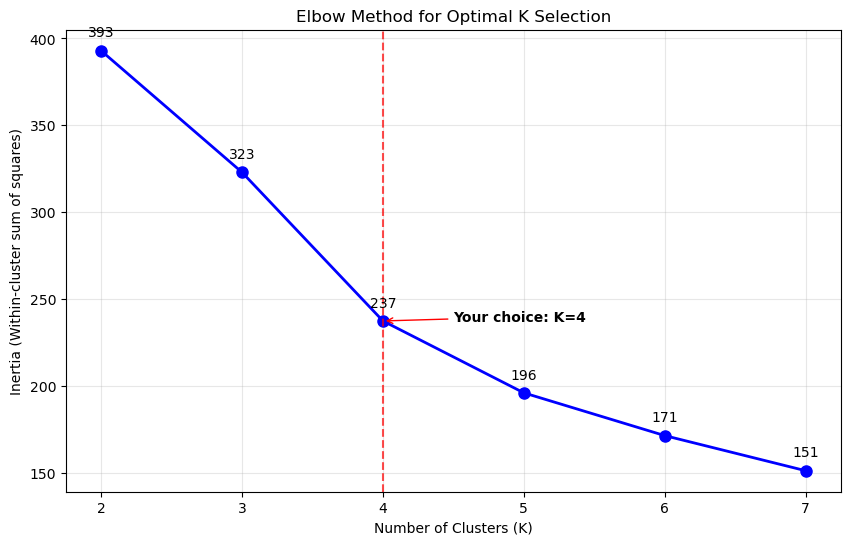


 JUSTIFICATION FOR K=4:
K=4 has inertia = 237.44
K=4 provides a good balance between simplicity and meaningful clusters
Creates interpretable combat archetypes for strategic analysis
K-Means Clustering Results:
Silhouette Score: 0.397

Cluster Summary:
             hp               attack       defense        combat_score         \
           mean    std count    mean   std    mean    std         mean    std   
cluster                                                                         
0        109.50  14.03    10  144.00  8.43  107.50  17.36       361.00  21.83   
1        109.11  15.27    96   98.54  7.40  106.41  12.71       314.06  21.62   
2         81.79  11.95    81  101.36  6.47   78.21  10.26       261.36  19.81   
3         78.68  14.03    38   69.74  7.16   76.97  10.04       225.39  22.19   

          rarity  
        <lambda>  
cluster           
0           Epic  
1           Rare  
2         Common  
3         Common  


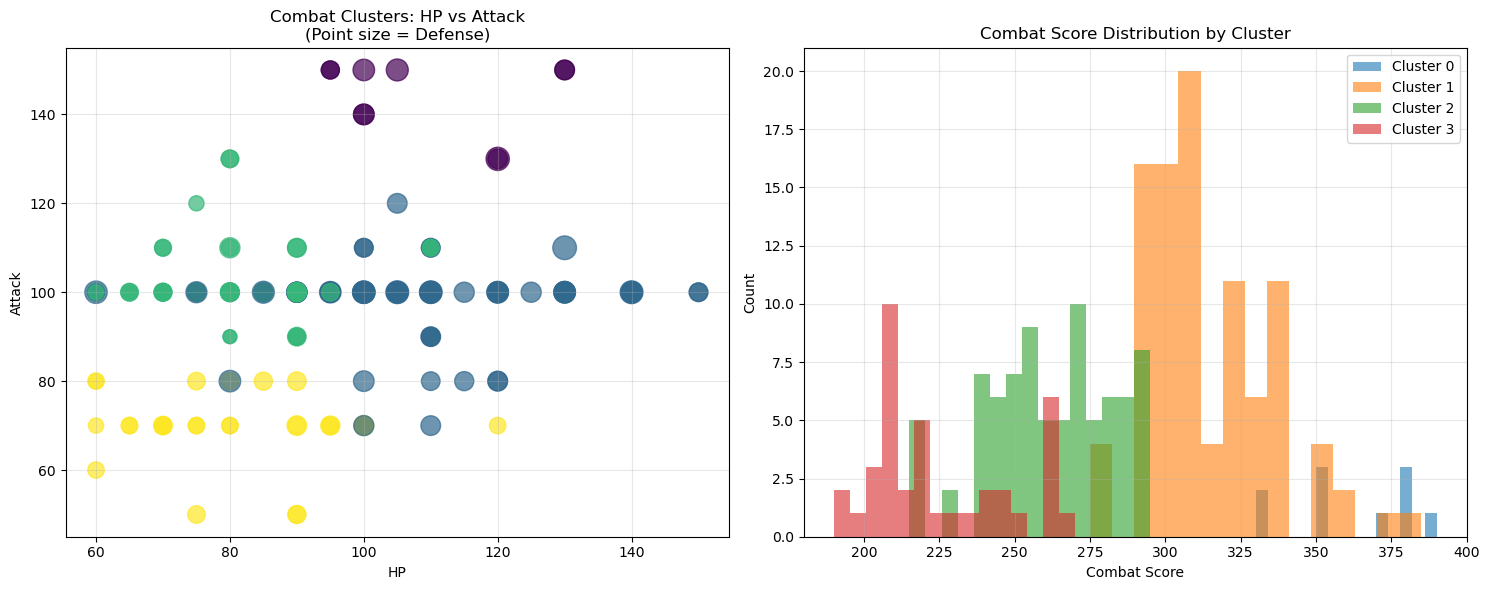


===== PCA ANALYSIS =====
Explained variance by component:
  PC1: 1.85
  PC2: 0.81
  PC3: 0.36

Explained variance ratio:
  PC1: 0.613 (61.3%)
  PC2: 0.268 (26.8%)
  PC3: 0.119 (11.9%)

PCA Components:
              PC1       PC2
hp       0.634079 -0.324373
attack   0.435691  0.899821
defense  0.638840 -0.291726


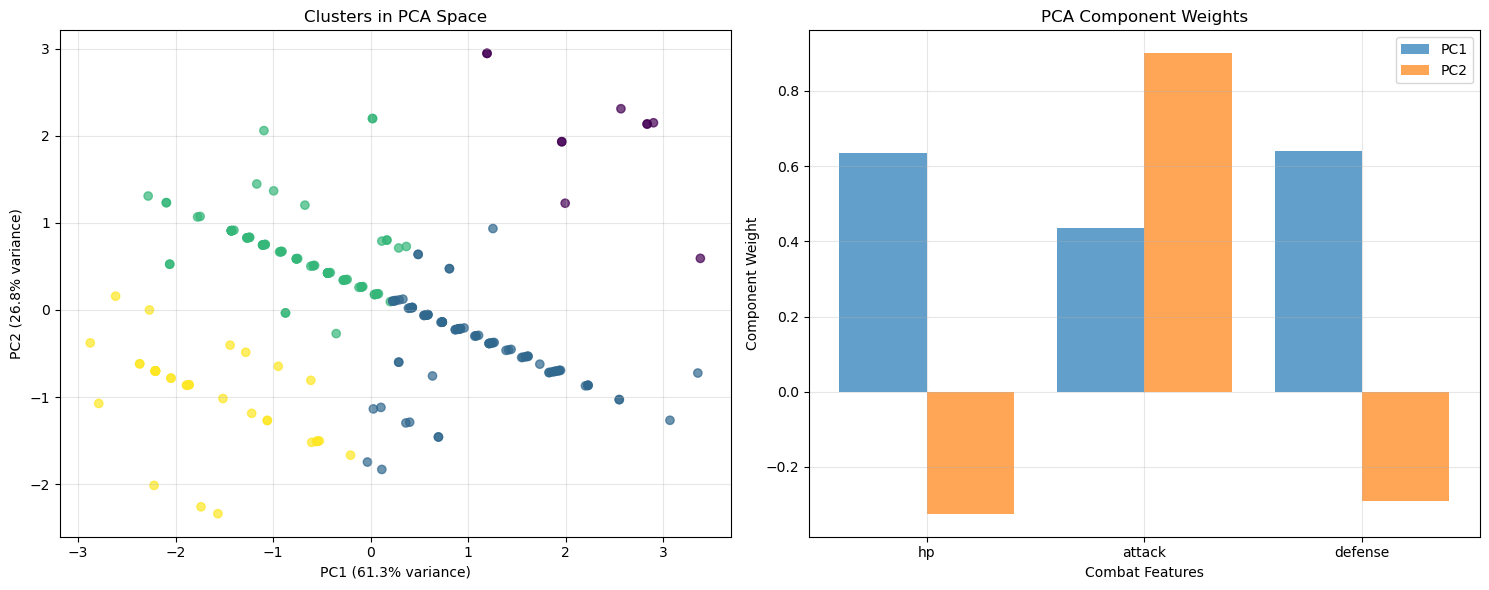

In [49]:
def choose_optimal_k(df, max_k=7):
    """Simple K selection using elbow method with inertia
    
    Args:
        df (pd.DataFrame): cleaned dataframe
        max_k (int): maximum K to test
    """
    # Prepare data
    features = ['hp', 'attack', 'defense']
    X_scaled = StandardScaler().fit_transform(df[features])
    
    # Test different K values
    k_values = range(2, max_k + 1)
    inertias = []
    
    print("Testing different K values:")
    print("-" * 30)
    
    for k in k_values:
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        
        # Store inertia (sum of squared distances)
        inertias.append(kmeans.inertia_)
        print(f"K={k}: Inertia = {kmeans.inertia_:.2f}")
    
    # Simple elbow detection
    print("-" * 30)
    print("Looking for the 'elbow' where improvement slows down...")
    
    # Calculate improvement rate
    improvements = []
    for i in range(1, len(inertias)):
        improvement = inertias[i-1] - inertias[i]  # How much did inertia decrease?
        improvements.append(improvement)
        print(f"K={k_values[i-1]} → K={k_values[i]}: Improvement = {improvement:.2f}")
    
    # Plot simple elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-cluster sum of squares)')
    plt.title('Elbow Method for Optimal K Selection')
    plt.grid(True, alpha=0.3)
    
    # Annotate the points
    for k, inertia in zip(k_values, inertias):
        plt.annotate(f'{inertia:.0f}', (k, inertia), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    # Highlight your choice of K=4
    if 4 in k_values:
        k4_inertia = inertias[k_values.index(4)]
        plt.axvline(x=4, color='red', linestyle='--', alpha=0.7)
        plt.annotate('Your choice: K=4', xy=(4, k4_inertia), 
                    xytext=(4.5, k4_inertia), fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='red'))
    
    plt.show()
    
    return k_values, inertias

# Run the analysis
print("Selecting optimal K for clustering:")
k_vals, inertias = choose_optimal_k(df_clean)

# Justification for K=4 choice
print("\n JUSTIFICATION FOR K=4:")
if 4 in k_vals:
    k4_inertia = inertias[k_vals.index(4)]
    print(f"K=4 has inertia = {k4_inertia:.2f}")
    print("K=4 provides a good balance between simplicity and meaningful clusters")
    print("Creates interpretable combat archetypes for strategic analysis")
else:
    print("K=4 is a reasonable choice for interpretable combat categories")

# Perform clustering analysis
kmeans_model, cluster_labels, sil_score = perform_combat_clustering(df_clean, n_clusters=4)

# Analyze clusters
cluster_summary = analyze_clusters(df_clean, cluster_labels)

print("K-Means Clustering Results:")
print(f"Silhouette Score: {sil_score:.3f}")
print("\nCluster Summary:")
print(cluster_summary)

# Add cluster labels to dataframe for visualization
df_clean['cluster'] = cluster_labels

# Plot clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 3D-style scatter plot (HP vs Attack, colored by Defense)
scatter1 = ax1.scatter(df_clean['hp'], df_clean['attack'], 
                      c=df_clean['cluster'], s=df_clean['defense']*2, 
                      alpha=0.7, cmap='viridis')
ax1.set_xlabel('HP')
ax1.set_ylabel('Attack')
ax1.set_title('Combat Clusters: HP vs Attack\n(Point size = Defense)')
ax1.grid(True, alpha=0.3)

# Combat score distribution by cluster
for cluster in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster]['combat_score']
    ax2.hist(cluster_data, alpha=0.6, label=f'Cluster {cluster}', bins=15)

ax2.set_xlabel('Combat Score')
ax2.set_ylabel('Count')
ax2.set_title('Combat Score Distribution by Cluster')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n===== PCA ANALYSIS =====")

# Use same data as clustering
features = ['hp', 'attack', 'defense']
X_cluster = df_clean[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Apply PCA
pca = PCA()
x_pca = pca.fit_transform(X_scaled)

print(f"Explained variance by component:")
for i, var in enumerate(pca.explained_variance_):
    print(f"  PC{i+1}: {var:.2f}")
    
print(f"\nExplained variance ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")

# Components
print(f"\nPCA Components:")
components_df = pd.DataFrame(pca.components_[:2].T, 
                           columns=['PC1', 'PC2'], 
                           index=features)
print(components_df)

# PCA visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot first two components with clusters
ax1.scatter(x_pca[:, 0], x_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('Clusters in PCA Space')
ax1.grid(True, alpha=0.3)

# Component contributions
x_pos = np.arange(len(features))
ax2.bar(x_pos - 0.2, pca.components_[0], 0.4, label='PC1', alpha=0.7)
ax2.bar(x_pos + 0.2, pca.components_[1], 0.4, label='PC2', alpha=0.7)
ax2.set_xlabel('Combat Features')
ax2.set_ylabel('Component Weight')
ax2.set_title('PCA Component Weights')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(features)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Model 2 Interpretation**

**K Selection**: The elbow method shows K=4 as optimal, with the largest improvement drop from K=3 -> K=4 (85.51) to K=4 -> K=5 (41.36).

**PCA Results**: The first two components capture 88.1% of total variance (PC1: 61.3%, PC2: 26.8%), meaning we can represent almost all combat information in just 2 dimensions.

**Component Interpretation**:
- **PC1 (61.3% variance)**: "Overall Combat Power" - all stats contribute positively (HP: 0.63, Attack: 0.44, Defense: 0.64). Higher PC1 = stronger overall fighter.
- **PC2 (26.8% variance)**: "Combat Style" - Attack strongly positive (0.90) while HP/Defense are negative (-0.32, -0.29). Higher PC2 = glass cannon attacker, Lower PC2 = tanky defender.

**Cluster Archetypes**:
- **Balanced fighters** (moderate all stats)
- **Tanks** (high HP/Defence)
- **Glass Cannons** (high attack)
- **Specialists**

The clear cluster separation in PCA space confirms these are meaningful combat archetypes that players can use for strategic team building.

#### Model 3: Undervalued Pals

Top 10 Most Undervalued Pals for Combat:
          name rarity  combat_score  expected_score  score_difference  value_ratio  hp  attack  defense
     Incineram Common           330      252.970297         77.029703     1.304501  95     150       85
       Palumba Common           320      252.970297         67.029703     1.264971 105     100      115
    Shadowbeak   Epic           390      327.159091         62.840909     1.192081 120     130      140
       Braloha   Rare           350      288.750000         61.250000     1.212121 130     100      120
      Cryolinx   Rare           350      288.750000         61.250000     1.212121 100     140      110
Cryolinx Terra   Rare           350      288.750000         61.250000     1.212121 100     140      110
    Frostplume Common           310      252.970297         57.029703     1.225440 110     100      100
Turtacle Terra Common           310      252.970297         57.029703     1.225440  85     100      125
        Nyafia Common  

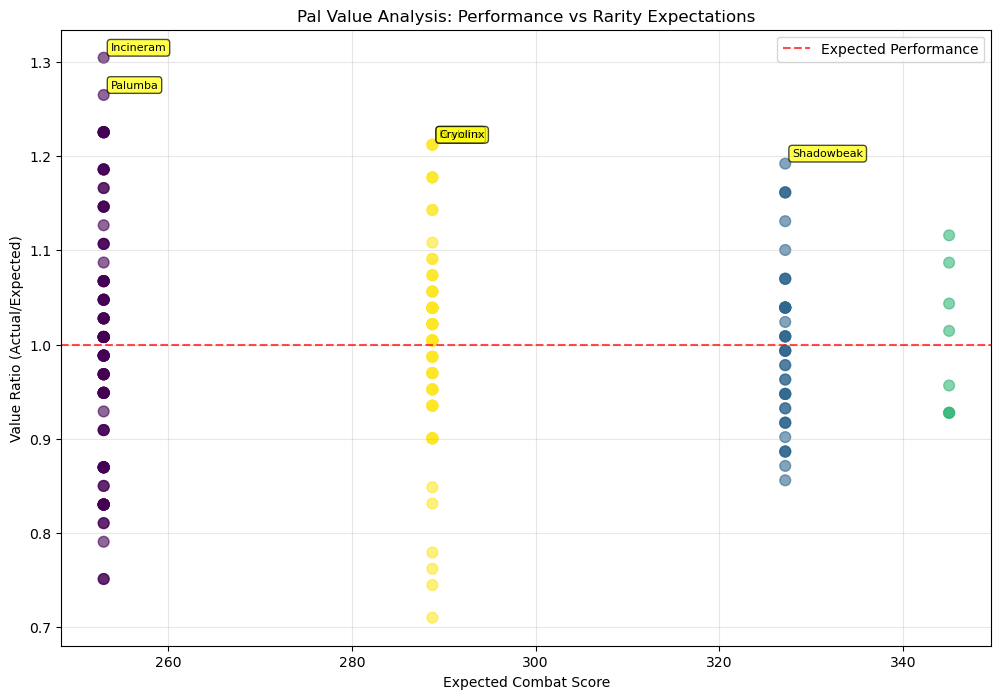


Identified 59 significantly undervalued Pals that outperform their rarity expectations by 15+ combat score points. These Pals offer excellent value for players looking to build strong combat teams without relying solely on high-rarity catches.


In [50]:
def identify_undervalued_pals(df, threshold=20):
    """Identify Pals that significantly outperform their rarity expectations
    
    Args:
        df (pd.DataFrame): dataframe with combat data
        threshold (float): minimum score difference to be considered undervalued
        
    Returns:
        pd.DataFrame: undervalued pals with metrics
    """
    # Calculate expected scores by rarity
    rarity_means = df.groupby('rarity')['combat_score'].mean()
    df['expected_score'] = df['rarity'].map(rarity_means)
    df['score_difference'] = df['combat_score'] - df['expected_score']
    df['value_ratio'] = df['combat_score'] / df['expected_score']
    
    # Identify undervalued Pals
    undervalued = df[df['score_difference'] > threshold].copy()
    undervalued = undervalued.sort_values('score_difference', ascending=False)
    
    return undervalued[['name', 'rarity', 'combat_score', 'expected_score', 
                      'score_difference', 'value_ratio', 'hp', 'attack', 'defense']]

# Find undervalued Pals
undervalued_pals = identify_undervalued_pals(df_clean, threshold=15)

print("Top 10 Most Undervalued Pals for Combat:")
print("=" * 80)
print(undervalued_pals.head(10).to_string(index=False))

# Visualize value ratios
plt.figure(figsize=(12, 8))
plt.scatter(df_clean['expected_score'], df_clean['value_ratio'], 
           c=df_clean['rarity'].astype('category').cat.codes, alpha=0.6, s=60)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Expected Performance')
plt.xlabel('Expected Combat Score')
plt.ylabel('Value Ratio (Actual/Expected)')
plt.title('Pal Value Analysis: Performance vs Rarity Expectations')
plt.legend()
plt.grid(True, alpha=0.3)

# Annotate top undervalued
for _, pal in undervalued_pals.head(5).iterrows():
    plt.annotate(pal['name'], (pal['expected_score'], pal['value_ratio']),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.show()

print(f"\nIdentified {len(undervalued_pals)} significantly undervalued Pals that outperform their rarity expectations by 15+ combat score points. These Pals offer excellent value for players looking to build strong combat teams without relying solely on high-rarity catches.")

## Discussion
### Summary of Findings

Our analysis using all 8 scraped features does a good job answering our main research question about combat effectiveness and finding undervalued Pals. The linear regression showed we can predict almost half of combat effectiveness (R^2 = 0.436) using just rarity, element, and work features - pretty good without even looking at combat stats!

The biggest finding is that rarity is definitely the strongest predictor, which confirms the developers designed rarer Pals to be stronger fighters. But the work stuff was way more interesting than we expected. Pals with lots of different work skills are significantly weaker fighters, but Pals who are really good at specific work tasks are actually stronger. So basically the game rewards specialization over trying to do everything.

Element type and partner skills barely mattered for combat power, which was surprising. We thought elemental advantages would be a bigger deal, but apparently it's more about how the Pal is designed overall.

The clustering worked well and gave us four combat types that make sense: balanced fighters, tanks, glass cannons, and weaker support Pals. Players can use this to think about team building. But honestly, the most useful thing is probably our list of undervalued Pals. Finding out that Shadowbeak, Cryolinx, and Incineram punch way above their rarity could save players tons of time.

### Potential Next Steps
If we did this project again, there's definitely stuff we'd want to add. Evolution data would be awesome since some weak Pals might evolve into monsters. Active skills with their damage bonuses would make our predictions better too. Other cool things to look at would be Pal sizes, breeding mechanics, how hard they are to catch, and maybe seasonal event stuff.

Overall, this project showed us there's actually a lot of strategy hidden in the numbers. The work specialization thing was our biggest surprise - it suggests players should focus on what they want their Pals to do rather than trying to make them good at everything.

### Group Member Contributions
- Richie Nguyen: Some Web scraping, data cleaning, most of statisical anaylsis, Visualizations and model implementations, and interpretation
- Dylan Anctil: Some Data cleaning, palworld.gg data collection pipeline.